In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import distance
from shapely.geometry import Point
from shapely.geometry import LineString
import math

# Base functions:

In [ ]:
# Four random points to start off with
points = np.array([[0, 0.8], [-0.15, 0.0], [0.15, -0.35], [0.2, 0.7]])

# eucl. distance
def dist(a, b):
  return distance.euclidean(a, b)

# smalled distance of a point in "points" to a given point
def get_smallest_dist(point):
  global points
  dists = [dist(p, point) for p in points]
  return min(dists)

# closest point on unit circle to a given point
def closest_point_on_circle(p):
  return [p[0] / dist(p, [0,0]),
          p[1] / dist(p, [0,0])]

# true if point is inside unit circle
def in_circle(p):
  return dist([0,0], p) <= 1.0

# true if edge intersects unti circle
def intersects_circle(p1, p2):
  return in_circle(p1) != in_circle(p2)

# intersection point of an edge with the unit circle boundary
def intersection_point(p1, p2):
  p = Point(0,0)
  c = p.buffer(1).boundary
  l = LineString([p1, p2])
  i = c.intersection(l)
  return [i.x, i.y]

# returns largest empty circle in a unit circle with samples
def get_largest_empty():
  global points
  vor = Voronoi(points)

  verts = vor.vertices
  verts_ = list(filter(lambda v:in_circle(v), vor.vertices))

  for (i1, i2) in vor.ridge_vertices:
    if intersects_circle(verts[i1], verts[i2]):
      verts_.append(intersection_point(verts[i1], verts[i2]))


  return max(verts_, key=lambda v:get_smallest_dist(v))

def add_new_sample():
  global points
  le = get_largest_empty()
  points = np.append(points, [le], axis=0)
  return le

# Adding Samples and displaying the final graph

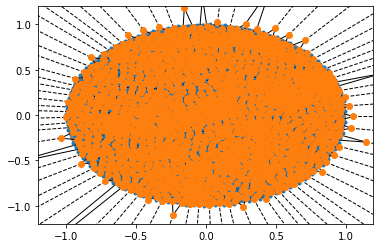

In [ ]:
# Add samples until we have 1024
samples = 1024 - 4
for i in range(samples):
  add_new_sample()

fig,ax = plt.subplots(1,1)
vor = Voronoi(points)
fig = voronoi_plot_2d(vor, ax)
ax.add_patch(plt.Circle((0, 0), 1, color='grey'))

plt.show()

# Projecting points from unit circle to unit hemisphere

In [ ]:
# transform points into 3d

points_3d = [[x,y,math.sqrt(1-(x*x + y*y))] for [x,y] in points]

# Output vectors in correct HLSL format. (This code is copied into the shader)

In [ ]:
# Output points:

print("static const uint sampledirs_len = "+str(len(points_3d))+ ";")
print("static const float3 sampledirs[sampledirs_len] = {")
for [x,y,z] in points_3d:
  print("\tfloat3("+str(x)+"f, "+str(y)+"f, "+str(z)+"f),")
print("};")

static const uint sampledirs_len = 1024;
static const float3 sampledirs[sampledirs_len] = {
	float3(0.0f, 0.8f, 0.5999999999999999f),
	float3(-0.15f, 0.0f, 0.9886859966642595f),
	float3(0.15f, -0.35f, 0.9246621004453465f),
	float3(0.2f, 0.7f, 0.6855654600401044f),
	float3(0.3960526315789472f, 0.1644736842105261f, 0.9033773963419756f),
	float3(-0.07500000000000012f, 0.4f, 0.9134412953222555f),
	float3(0.15936352509179913f, -0.03840269277845787f, 0.9864727568755657f),
	float3(0.5072787154544864f, -0.20479691425626478f, 0.8370940979113151f),
	float3(0.22152255639097737f, 0.4042293233082706f, 0.8874268483586374f),
	float3(0.7283599624060153f, 0.5897791353383455f, 0.3487869502769013f),
	float3(0.898444858448487f, 0.11441042863127807f, 0.42391873059335966f),
	float3(0.5089335810678658f, 0.8594225457465681f, 0.0487800976211223f),
	float3(0.663079897311403f, 0.2983100278446798f, 0.6865392756928081f),
	float3(0.44843414339419996f, 0.5694095730397422f, 0.6889699247202368f),
	float3(0.21313292216

# Display points in 3D view

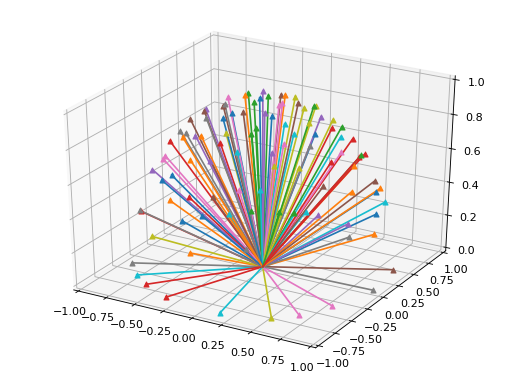

In [ ]:
fig = plt.figure(figsize=(8, 6), dpi=80)
ax = fig.add_subplot(projection='3d')

ax.set_zlim(0, 1)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

for [x,y,z] in points_3d:
    ax.scatter(x, y, z, marker='^')
    ax.plot([0, 1*x], [0, 1*y], zs=[0, 1*z])

plt.show()

# Display Voronoi diagram of 3D view

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


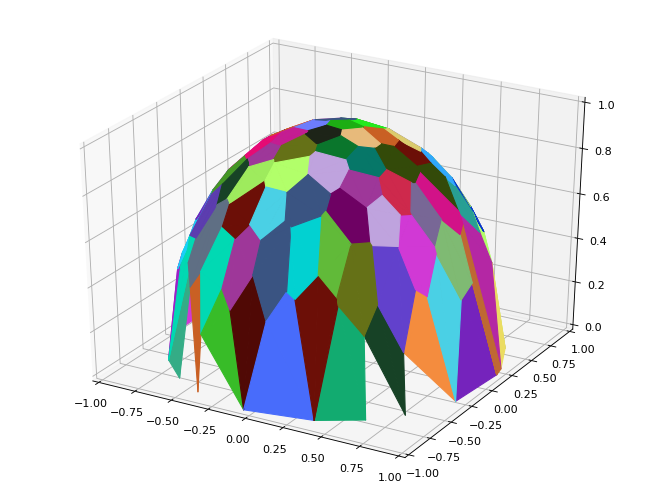

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay
import random

fig = plt.figure(figsize=(8, 6), dpi=80)
ax = Axes3D(fig)

ax.set_zlim(0, 1)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

vor = Voronoi(points)
verts = vor.vertices

cols = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(100)]

#print(vor.regions[2])

for pol in vor.regions:
  col = random.choice(cols)

  if len(pol) > 2:
    # This line gets rid of the "point at infinity", because those have an index of -1
    #if any([i<0 for i in pol]):
    #  continue

    polygon=[]
    lg = 0
    for i in reversed(pol):
      if i >= 0:
        lg = i
        break
    ng = 0

    for j in range(len(pol)):
      i = pol[j]

      if i >= 0:
        lg = i
        ng = 0
      else:
        if ng > 1:
          q = j + 1
          while True:
            if pol[q] >= 0:
              lg = q
              break
            q += 1
        ng += 1

      if i < 0:
        polygon.append(closest_point_on_circle(verts[lg]))
        continue
      elif not in_circle(verts[i]):
        polygon.append(closest_point_on_circle(verts[i]))
      else:
        polygon.append(verts[i])
    polygon = np.array(polygon)

    hull = Delaunay(polygon)
    for s in hull.simplices:
      try:
        pol3d = np.array([[x,y,math.sqrt(1-(x*x + y*y))] for [x,y] in polygon[s]])
      except ValueError:
        pol3d = np.array([[x,y,0] for [x,y] in polygon[s]])
      tri = Poly3DCollection(pol3d)
      tri.set_color(col)
      #tri.set_alpha(0.5)
      ax.add_collection3d(tri)

#for [x,y,z] in points_3d:
    #ax.scatter(x, y, z, marker='^')
    #ax.plot([0, 1.5*x], [0, 1.5*y], zs=[0, 1.5*z])


plt.show()